## Imports

In [13]:
# Imports
import pandas as pd
import numpy as np

## Carga de datos

En el dataset, los datos no definidos (missing) estan especificados con un simbolo de interrogacion.

In [8]:
data = pd.read_csv('dataset/automobile.csv', na_values=['?'])
data.columns

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')

### Definimos que atributos son categoricos

Notese que especificamos como ordenados aquellos atributos que lo merecen, como son el numero de puertas y el numero de cilindros. Entre categorias, hay una relacion de tamano que puede ser util posteriormente.

In [55]:
data.symboling          = pd.Categorical(data.symboling)
data.make               = pd.Categorical(data.make)
data.fuel_type          = pd.Categorical(data.fuel_type)
data.aspiration         = pd.Categorical(data.aspiration)
data.num_of_doors       = pd.Categorical(data.num_of_doors,['two', 'four'], ordered=True)
data.body_style         = pd.Categorical(data.body_style)
data.drive_wheels       = pd.Categorical(data.drive_wheels)
data.engine_location    = pd.Categorical(data.engine_location)
data.engine_type        = pd.Categorical(data.engine_type)
data.num_of_cylinders   = pd.Categorical(data.num_of_cylinders, ['four', 'five', 'six', 'eight'], ordered=True)
data.fuel_system        = pd.Categorical(data.fuel_system)

## Valores faltantes (Missing Values)
Nuestro dataset ya especicaba los valores missing con un '?'. A pesar de ello, creemos adecuado comprobar que no haya valores extranos, como podrian ser ceros, o numeros como 999999.

In [56]:
data.describe()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,164.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,35.442168,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,150.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


Vemos que tanto los minimos como los maximos de todas las variables continuas no parecen ser errores, sino datos reales.

## Inspeccion de los diferentes atributos

### Atributos continuos

In [53]:
data.describe()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,205.000000,164.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,0.834146,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,1.245307,35.442168,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,150.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


### Atributos categoricos

0     67
1     54
2     32
3     27
-1    22
-2     3
Name: symboling, dtype: int64


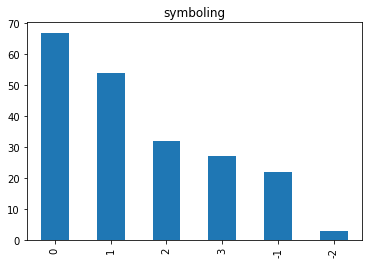

In [57]:
print(data['symboling'].value_counts())
data['symboling'].value_counts().plot(kind='bar', title='symboling');

gas       185
diesel     20
Name: fuel_type, dtype: int64


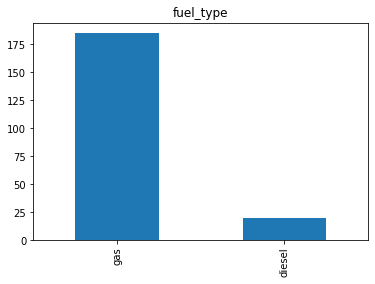

In [44]:
print(data['fuel_type'].value_counts())
data['fuel_type'].value_counts().plot(kind='bar', title='fuel_type');

std      168
turbo     37
Name: aspiration, dtype: int64


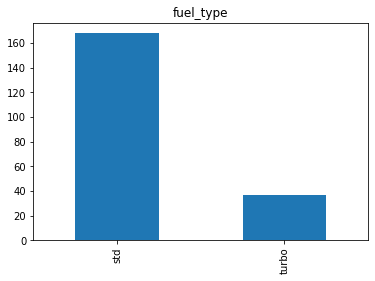

In [45]:
print(data['aspiration'].value_counts())
data['aspiration'].value_counts().plot(kind='bar', title='fuel_type');

four    114
two      89
Name: num_of_doors, dtype: int64


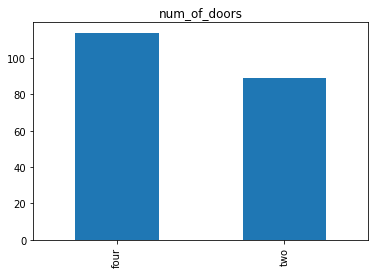

In [46]:
print(data['num_of_doors'].value_counts())
data['num_of_doors'].value_counts().plot(kind='bar', title='num_of_doors');

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: body_style, dtype: int64


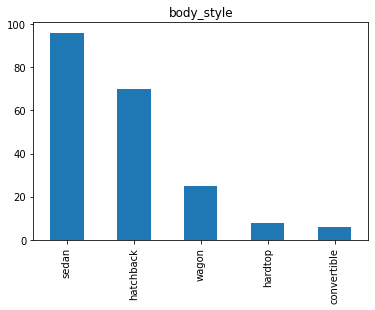

In [47]:
print(data['body_style'].value_counts())
data['body_style'].value_counts().plot(kind='bar', title='body_style');

fwd    120
rwd     76
4wd      9
Name: drive_wheels, dtype: int64


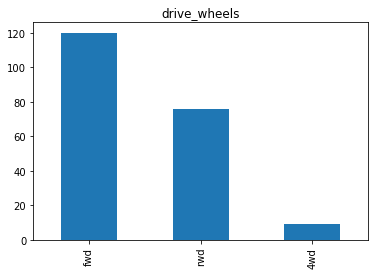

In [48]:
print(data['drive_wheels'].value_counts())
data['drive_wheels'].value_counts().plot(kind='bar', title='drive_wheels');

front    202
rear       3
Name: engine_location, dtype: int64


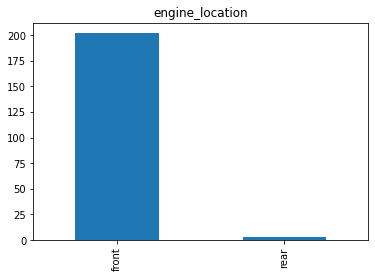

In [49]:
print(data['engine_location'].value_counts())
data['engine_location'].value_counts().plot(kind='bar', title='engine_location');

ohc      148
ohcf      15
ohcv      13
l         12
dohc      12
rotor      4
dohcv      1
Name: engine_type, dtype: int64


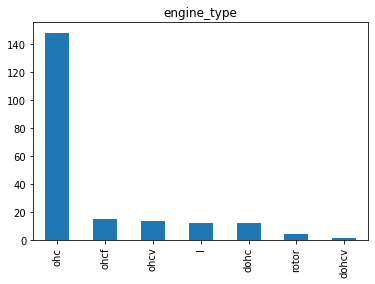

In [50]:
print(data['engine_type'].value_counts())
data['engine_type'].value_counts().plot(kind='bar', title='engine_type');

four     159
six       24
five      11
eight      5
Name: num_of_cylinders, dtype: int64


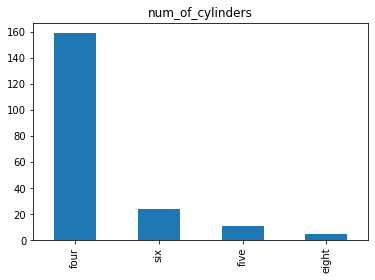

In [51]:
print(data['num_of_cylinders'].value_counts())
data['num_of_cylinders'].value_counts().plot(kind='bar', title='num_of_cylinders');

mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
spfi     1
mfi      1
Name: fuel_system, dtype: int64


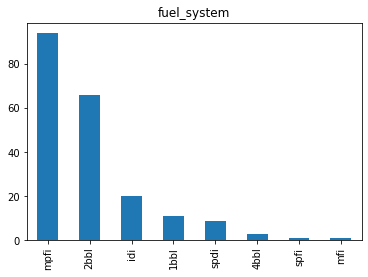

In [52]:
print(data['fuel_system'].value_counts())
data['fuel_system'].value_counts().plot(kind='bar', title='fuel_system');